# Assign barcodes

Load in modules, define some variables.

In [1]:
import pandas as pd
import json
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import datashader as ds
from datashader.mpl_ext import dsshow
from multiprocessing import Pool
import glob
import os
import sys


sys.path.append('Scripts')
import GuideAssign

colormap = 'colorblind'
colors = sns.color_palette(colormap, 8)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 12, 'axes.titlesize':'medium',})
numProcessors = 2
import scipy
from scipy import stats
from statsmodels.stats import multitest
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def using_datashader(ax, x, y, vmax):

    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        vmin=0,
        vmax=vmax,
        norm="linear",
        aspect="auto",
        ax=ax, rasterized=True
    )

    plt.colorbar(dsartist)


## Barcode assignment

Using R2 only, go ahead and define all guide sequences. use pre-existing guide annotations. Only retain reads for analysis that contain adapter sequences.

Start with a lower depth RNA, but this is replaced in the next section with a less-bottlenecked version.

These data are from an MOI 2 infection using ∆NS1 at 8hpi. 

In [1]:
if not os.path.isdir('Results/FirstRun'):
    os.mkdir('Results/FirstRun')
def analyze(file):
    unzipped = file[:-3]
    name = os.path.basename(file)
    replicate = name.split('-')[1][0]
    molecule = name.split('-')[0][-3:]
    !gunzip -c $file | grep -i CGGTGTTTCG | grep -i CTAGCTCTAAAAC > $unzipped
    GuideAssign.quickAssign(infile = unzipped, outfile = 'Results/FirstRun/' + replicate + '_' + molecule + '.tsv', upSeq = 'CTAGCTCTAAAAC', downSeq='CGGTGTTTCG', guideLength=20,
                           guideDirectory='Database/guides')
    !rm -f $unzipped

popList = [file for file in glob.glob('Sequencing/*R2*.gz')]
while len(popList) > 0:
    with Pool(processes = numProcessors) as p:
        p.map(analyze, [popList.pop() for i in range(numProcessors) if len(popList) != 0])

NameError: name 'os' is not defined

Original RNA sequencing was only 0.5µg, and used oligoDT. Using a gene-specific primer, at 20µg, we generated a higher-depth sample.

In [4]:
if not os.path.isdir('Results/moreDepth'):
    os.mkdir('Results/moreDepth')
def analyze(file):
    unzipped = file[:-3]
    name = os.path.basename(file)
    replicate = name.split('_')[0][-1]
    molecule = 'RNA'
    !gunzip -c $file | grep -i CGAAACACCG | grep -i GTTTTAGAGCTAG > $unzipped
    GuideAssign.quickAssign(infile = unzipped, outfile = 'Results/moreDepth/' + replicate + '_' + molecule + '.tsv', upSeq = 'CGAAACACCG', downSeq='GTTTTAGAGCTAG', guideLength=20,
                           guideDirectory='Database/guides', rc=False)
    !rm -f $unzipped

popList = [file for file in glob.glob('Sequencing/MoreDepth/*_R1_*.gz')]
while len(popList) > 0:
    with Pool(processes = numProcessors) as p:
        p.map(analyze, [popList.pop() for i in range(numProcessors) if len(popList) != 0])

# Load in assessments of libraries

Read in all data for further thresholding and analysis.

In [21]:

rawCounts = []
for file in glob.glob('Results/FirstRun/*DNA.tsv'):
    replicate = os.path.basename(file).split('_')[0]
    currFrame = pd.read_csv(file, sep='\t')
    currFrame['molecule'] = 'DNA'
    currFrame['replicate'] = replicate
    currFrame['Sequencing'] = ''
    rawCounts += [currFrame]
for file in glob.glob('Results/FirstRun/*RNA.tsv'):
    replicate = os.path.basename(file).split('_')[0]
    currFrame = pd.read_csv(file, sep='\t')
    currFrame['molecule'] = 'RNA'
    currFrame['replicate'] = replicate
    currFrame['Sequencing'] = 'low input'
    rawCounts += [currFrame]

for file in glob.glob('Results/moreDepth/*RNA.tsv'):
    replicate = os.path.basename(file).split('_')[0]
    currFrame = pd.read_csv(file, sep='\t')
    currFrame['molecule'] = 'RNA'
    currFrame['replicate'] = replicate
    currFrame['Sequencing'] = 'high input'
    rawCounts += [currFrame]
    
rawCounts = pd.concat(rawCounts)


Quick check, for each condition, how many guides were unknown (ie those that had correct up and down sequences?). Is it a worrying amount? Is it similar across all conditions?

Ultimately it is consistently ~20%. This may be due to errors in illumina sequencing. Rather than attempt to recover these using "fuzzy matching" the gains would be marginal, so no need in my opinion.

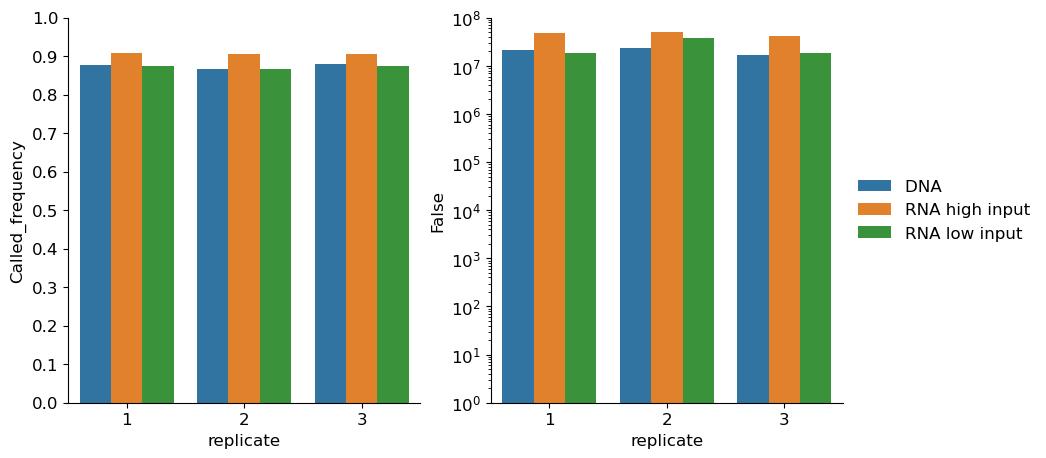

In [22]:
plot = rawCounts.copy()
plot['unknown'] = plot.UID == 'unknown'
plot = plot.groupby(['unknown','molecule','replicate', 'Sequencing']).occurrences.sum().reset_index()
plot = plot.pivot_table(index=['replicate','molecule', 'Sequencing'], columns=['unknown'], values=['occurrences']).reset_index()
plot['Called_frequency'] = plot.occurrences[False]/(plot.occurrences[False] + plot.occurrences[True])
plot['category'] = plot.molecule + ' ' + plot.Sequencing 
f, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(x=plot.replicate, y=plot.Called_frequency, ax=axes[0], hue=plot.category)
sns.despine()
axes[0].get_legend().remove()
plt.ylim(0, 1)
axes[0].set_yticks(np.arange(0,1.1,0.1))
sns.barplot(x=plot.replicate, y=plot.occurrences[False], ax=axes[1], hue=plot.category)
sns.despine()
plt.yscale('log')
plt.ylim(1, 100000000)
axes[1].legend( loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)


Remove unknowns from data. Of the remaining, how many guides are absent under each condition.

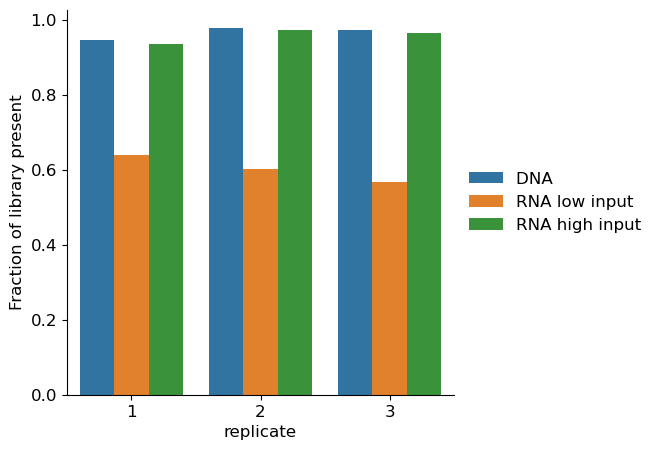

In [27]:
rawCounts = rawCounts[rawCounts.UID != 'unknown']
plot = rawCounts.copy()
plot['absent'] = plot.occurrences == 0
plot = plot.groupby(['absent','molecule','replicate', 'Sequencing']).occurrences.count().reset_index()
plot = plot.pivot_table(index=['replicate','molecule','Sequencing'], columns=['absent'], values=['occurrences']).reset_index()
plot['Present_frequency'] = plot.occurrences[False]/(plot.occurrences[False] + plot.occurrences[True])
plot['category'] = plot.molecule + ' ' + plot.Sequencing 

f, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x=plot.replicate, y=plot.Present_frequency, ax=axes, hue=plot.category, hue_order=['DNA ', 'RNA low input','RNA high input'])

sns.despine()
axes.legend( loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.ylabel('Fraction of library present')
plt.savefig('DELETE.png',bbox_inches="tight")


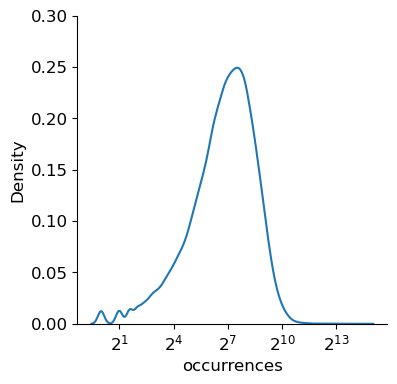

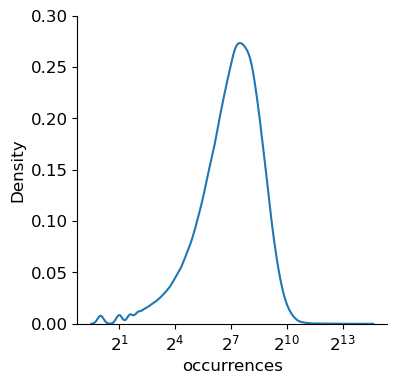

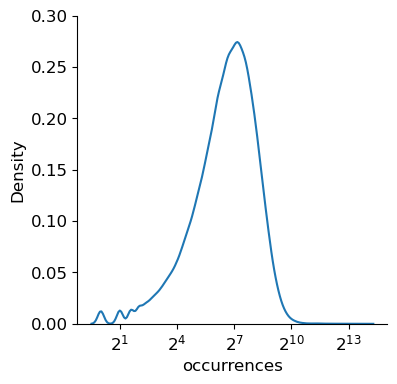

In [24]:
plot = rawCounts.copy()

plot = plot.loc[(plot.molecule == 'DNA') & (plot.occurrences > 0),]


fig,ax = plt.subplots(figsize=(4,4))
sns.kdeplot(data=plot[plot.replicate == '1'], x='occurrences', log_scale=2)
plt.ylim(0,0.3)
sns.despine()
plt.savefig('Figures/DNA-1_dist.pdf', format='pdf', bbox_inches = "tight")

fig,ax = plt.subplots(figsize=(4,4))
sns.kdeplot(data=plot[plot.replicate == '2'], x='occurrences', log_scale=2)
plt.ylim(0,0.3)
sns.despine()
plt.savefig('Figures/DNA-2_dist.pdf', format='pdf', bbox_inches = "tight")

fig,ax = plt.subplots(figsize=(4,4))
sns.kdeplot(data=plot[plot.replicate == '3'], x='occurrences', log_scale=2)
plt.ylim(0,0.3)
sns.despine()
plt.savefig('Figures/DNA-3_dist.pdf', format='pdf', bbox_inches = "tight")

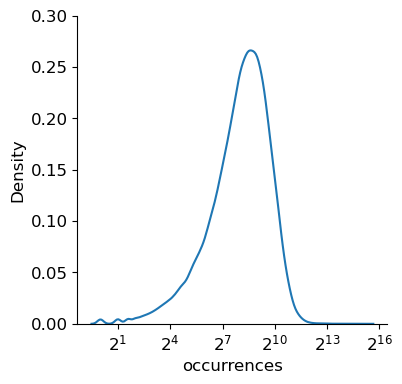

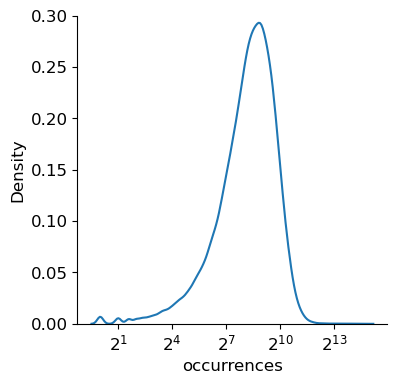

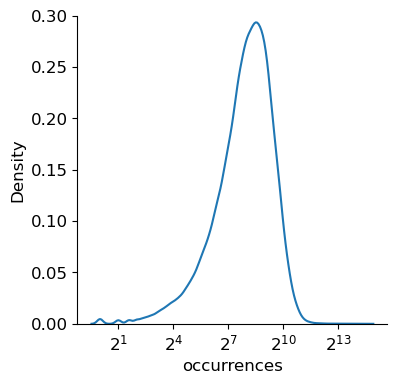

In [26]:
plot = rawCounts.copy()

plot = plot.loc[(plot.molecule == 'RNA') & (plot.occurrences > 0) & (plot.Sequencing == 'second'),]


fig,ax = plt.subplots(figsize=(4,4))
sns.kdeplot(data=plot[plot.replicate == '1'], x='occurrences', log_scale=2)
plt.ylim(0,0.3)
sns.despine()
plt.savefig('Figures/RNA-1_dist.pdf', format='pdf', bbox_inches = "tight")

fig,ax = plt.subplots(figsize=(4,4))
sns.kdeplot(data=plot[plot.replicate == '2'], x='occurrences', log_scale=2)
plt.ylim(0,0.3)
sns.despine()
plt.savefig('Figures/RNA-2_dist.pdf', format='pdf', bbox_inches = "tight")

fig,ax = plt.subplots(figsize=(4,4))
sns.kdeplot(data=plot[plot.replicate == '3'], x='occurrences', log_scale=2)
plt.ylim(0,0.3)
sns.despine()
plt.savefig('Figures/RNA-3_dist.pdf', format='pdf', bbox_inches = "tight")

Now lets start to look at correlations. Remove lower depth data for this one. RNA first

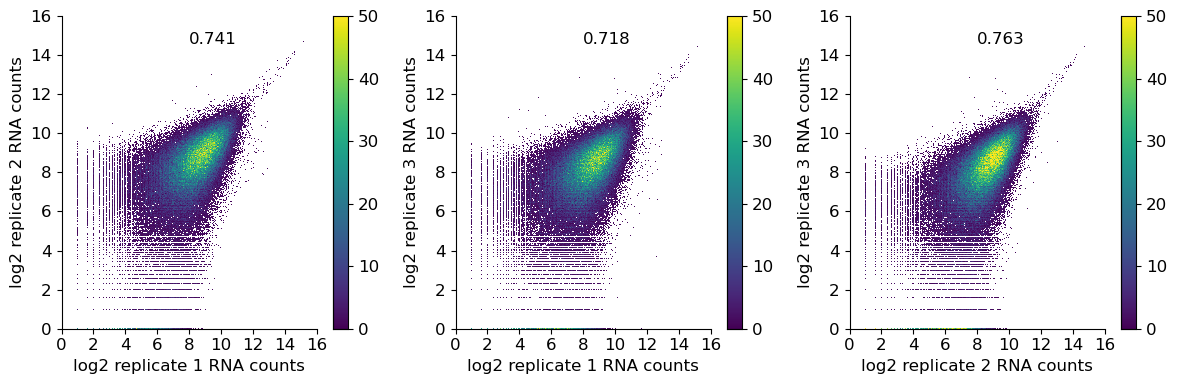

In [12]:
fig, axes = plt.subplots(figsize=(12,4), ncols =3)

plot = rawCounts.copy()
plot = plot.loc[(plot.Sequencing != 'first') | (plot.molecule == 'DNA'),]

RNA = plot.loc[plot.molecule == 'RNA',]
RNA = RNA.pivot(index = 'UID', columns = 'replicate', values = 'occurrences')
using_datashader(axes[0], np.log2(RNA['1'] + 1), np.log2(RNA['2'] +1), 50)
plt.sca(axes[0])
plt.xlabel('log2 replicate 1 RNA counts')
plt.ylabel('log2 replicate 2 RNA counts')
axes[0].text(0.5, 0.95, str(str(RNA.corr()['2']['1'].round(3))), transform=axes[0].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(0,16)
plt.ylim(0,16)
plt.xticks(np.arange(0,18,2))
                 
using_datashader(axes[1], np.log2(RNA['1'] + 1), np.log2(RNA['3'] +1), 50)
plt.sca(axes[1])
plt.xlabel('log2 replicate 1 RNA counts')
plt.ylabel('log2 replicate 3 RNA counts')
axes[1].text(0.5, 0.95, str(str(RNA.corr()['3']['1'].round(3))), transform=axes[1].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(0,16)
plt.ylim(0,16)
plt.xticks(np.arange(0,18,2))


using_datashader(axes[2], np.log2(RNA['2'] + 1), np.log2(RNA['3'] +1), 50)
plt.sca(axes[2])
plt.xlabel('log2 replicate 2 RNA counts')
plt.ylabel('log2 replicate 3 RNA counts')
axes[2].text(0.5, 0.95, str(str(RNA.corr()['2']['3'].round(3))), transform=axes[2].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(0,16)
plt.ylim(0,16)
plt.xticks(np.arange(0,18,2))



plt.tight_layout()
sns.despine()
plt.savefig('Figures/RNAcorrMain.pdf')

Now DNA

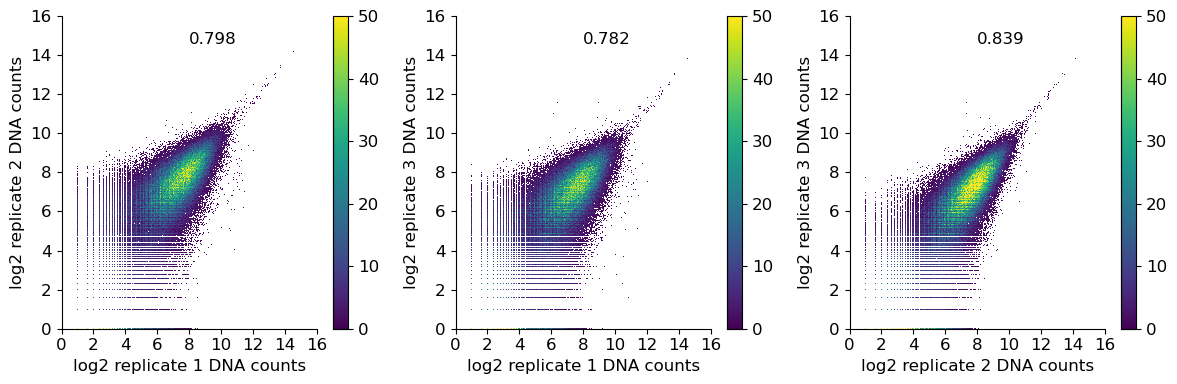

In [7]:
fig, axes = plt.subplots(figsize=(12,4), ncols =3)


DNA = plot.loc[plot.molecule == 'DNA',]
DNA = DNA.pivot(index = 'UID', columns = 'replicate', values = 'occurrences')
using_datashader(axes[0], np.log2(DNA['1'] + 1), np.log2(DNA['2'] +1), 50)
plt.sca(axes[0])
plt.xlabel('log2 replicate 1 DNA counts')
plt.ylabel('log2 replicate 2 DNA counts')
axes[0].text(0.5, 0.95, str(str(DNA.corr()['2']['1'].round(3))), transform=axes[0].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(0,16)
plt.ylim(0,16)
plt.xticks(np.arange(0,18,2))
                 
using_datashader(axes[1], np.log2(DNA['1'] + 1), np.log2(DNA['3'] +1), 50)
plt.sca(axes[1])
plt.xlabel('log2 replicate 1 DNA counts')
plt.ylabel('log2 replicate 3 DNA counts')
axes[1].text(0.5, 0.95, str(str(DNA.corr()['3']['1'].round(3))), transform=axes[1].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(0,16)
plt.ylim(0,16)
plt.xticks(np.arange(0,18,2))


using_datashader(axes[2], np.log2(DNA['2'] + 1), np.log2(DNA['3'] +1), 50)
plt.sca(axes[2])
plt.xlabel('log2 replicate 2 DNA counts')
plt.ylabel('log2 replicate 3 DNA counts')
axes[2].text(0.5, 0.95, str(str(DNA.corr()['2']['3'].round(3))), transform=axes[2].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(0,16)
plt.ylim(0,16)
plt.xticks(np.arange(0,18,2))



plt.tight_layout()
sns.despine()
plt.savefig('Figures/DNAcorrMain.pdf')

If assumptions are correct that most have no signal, then roughly DNA=DNA

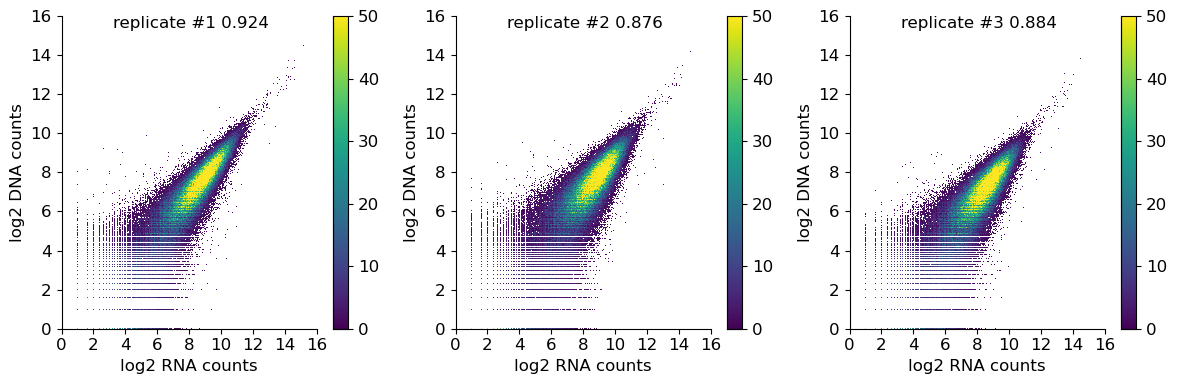

In [8]:
fig, axes = plt.subplots(figsize=(12,4), ncols =3)

graph = plot.pivot_table(index = ['UID','replicate'], columns = ['molecule'], values = 'occurrences').reset_index()



using_datashader(axes[0], np.log2(graph[graph.replicate == '1'].RNA + 1), np.log2(graph[graph.replicate == '1'].DNA +1), 50)
plt.sca(axes[0])
plt.xlabel('log2 RNA counts')
plt.ylabel('log2 DNA counts')
axes[0].text(0.2, 1, 'replicate #1 ' + str(graph[graph.replicate == '1'][['DNA','RNA']].corr().RNA.DNA.round(3)), transform=axes[0].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(0,16)
plt.ylim(0,16)
plt.xticks(np.arange(0,18,2))
                 
using_datashader(axes[1], np.log2(graph[graph.replicate == '2'].RNA + 1), np.log2(graph[graph.replicate == '2'].DNA +1), 50)
plt.sca(axes[1])
plt.xlabel('log2 RNA counts')
plt.ylabel('log2 DNA counts')
axes[1].text(0.2, 1, 'replicate #2 ' + str(graph[graph.replicate == '2'][['DNA','RNA']].corr().RNA.DNA.round(3)), transform=axes[1].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(0,16)
plt.ylim(0,16)
plt.xticks(np.arange(0,18,2))



using_datashader(axes[2], np.log2(graph[graph.replicate == '3'].RNA + 1), np.log2(graph[graph.replicate == '3'].DNA +1), 50)
plt.sca(axes[2])
plt.xlabel('log2 RNA counts')
plt.ylabel('log2 DNA counts')
axes[2].text(0.2, 1, 'replicate #3 ' + str(graph[graph.replicate == '3'][['DNA','RNA']].corr().RNA.DNA.round(3)), transform=axes[2].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(0,16)
plt.ylim(0,16)
plt.xticks(np.arange(0,18,2))



plt.tight_layout()
sns.despine()
plt.savefig('Figures/DNARNAcorrMain.pdf')

Same graphs at gene level


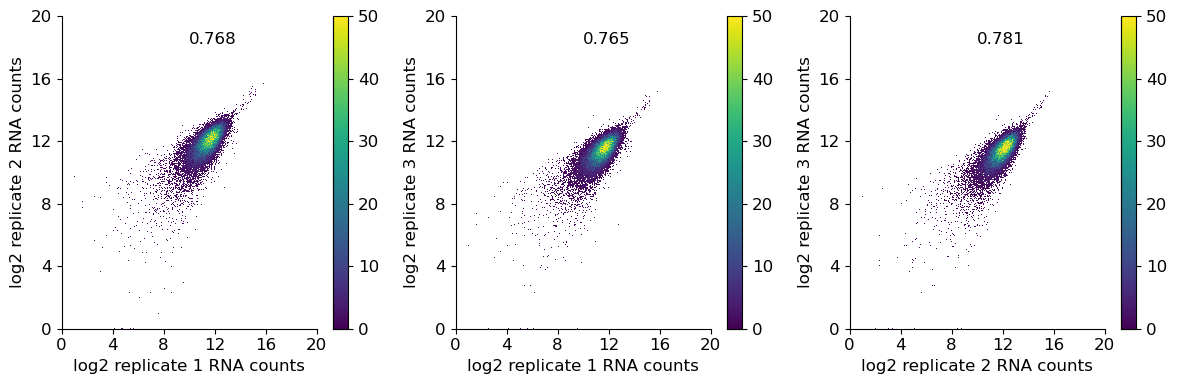

In [13]:
fig, axes = plt.subplots(figsize=(12,4), ncols =3)

plot = rawCounts.copy()


RNA = plot.loc[plot.molecule == 'RNA',]
RNA = RNA.pivot_table(index = 'gene_ID', columns = 'replicate', values = 'occurrences', aggfunc='sum')
using_datashader(axes[0], np.log2(RNA['1'] + 1), np.log2(RNA['2'] +1), 50)
plt.sca(axes[0])
plt.xlabel('log2 replicate 1 RNA counts')
plt.ylabel('log2 replicate 2 RNA counts')
axes[0].text(0.5, 0.95, str(str(RNA.corr()['2']['1'].round(3))), transform=axes[0].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(0,20)
plt.ylim(0,20)
plt.xticks(np.arange(0,22,4))
plt.yticks(np.arange(0,22,4))
      
using_datashader(axes[1], np.log2(RNA['1'] + 1), np.log2(RNA['3'] +1), 50)
plt.sca(axes[1])
plt.xlabel('log2 replicate 1 RNA counts')
plt.ylabel('log2 replicate 3 RNA counts')
axes[1].text(0.5, 0.95, str(str(RNA.corr()['3']['1'].round(3))), transform=axes[1].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(0,20)
plt.ylim(0,20)
plt.xticks(np.arange(0,22,4))
plt.yticks(np.arange(0,22,4))


using_datashader(axes[2], np.log2(RNA['2'] + 1), np.log2(RNA['3'] +1), 50)
plt.sca(axes[2])
plt.xlabel('log2 replicate 2 RNA counts')
plt.ylabel('log2 replicate 3 RNA counts')
axes[2].text(0.5, 0.95, str(str(RNA.corr()['2']['3'].round(3))), transform=axes[2].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(0,20)
plt.ylim(0,20)
plt.xticks(np.arange(0,22,4))
plt.yticks(np.arange(0,22,4))



plt.tight_layout()
sns.despine()


plt.savefig('Figures/RNAcorrMainGene.pdf')


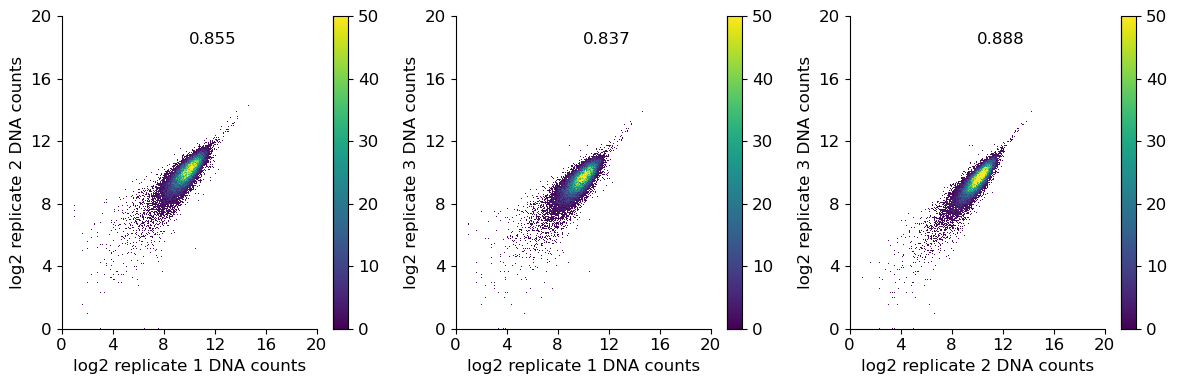

In [14]:
fig, axes = plt.subplots(figsize=(12,4), ncols =3)

plot = rawCounts.copy()


DNA = plot.loc[plot.molecule == 'DNA',]
DNA = DNA.pivot_table(index = 'gene_ID', columns = 'replicate', values = 'occurrences', aggfunc='sum')
using_datashader(axes[0], np.log2(DNA['1'] + 1), np.log2(DNA['2'] +1), 50)
plt.sca(axes[0])
plt.xlabel('log2 replicate 1 DNA counts')
plt.ylabel('log2 replicate 2 DNA counts')
axes[0].text(0.5, 0.95, str(str(DNA.corr()['2']['1'].round(3))), transform=axes[0].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(0,20)
plt.ylim(0,20)
plt.xticks(np.arange(0,22,4))
plt.yticks(np.arange(0,22,4))


using_datashader(axes[1], np.log2(DNA['1'] + 1), np.log2(DNA['3'] +1), 50)
plt.sca(axes[1])
plt.xlabel('log2 replicate 1 DNA counts')
plt.ylabel('log2 replicate 3 DNA counts')
axes[1].text(0.5, 0.95, str(str(DNA.corr()['3']['1'].round(3))), transform=axes[1].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(0,20)
plt.ylim(0,20)
plt.xticks(np.arange(0,22,4))
plt.yticks(np.arange(0,22,4))


using_datashader(axes[2], np.log2(DNA['2'] + 1), np.log2(DNA['3'] +1), 50)
plt.sca(axes[2])
plt.xlabel('log2 replicate 2 DNA counts')
plt.ylabel('log2 replicate 3 DNA counts')
axes[2].text(0.5, 0.95, str(str(DNA.corr()['2']['3'].round(3))), transform=axes[2].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(0,20)
plt.ylim(0,20)
plt.xticks(np.arange(0,22,4))
plt.yticks(np.arange(0,22,4))



plt.tight_layout()
sns.despine()


plt.savefig('Figures/DNAcorrMainGene.pdf')


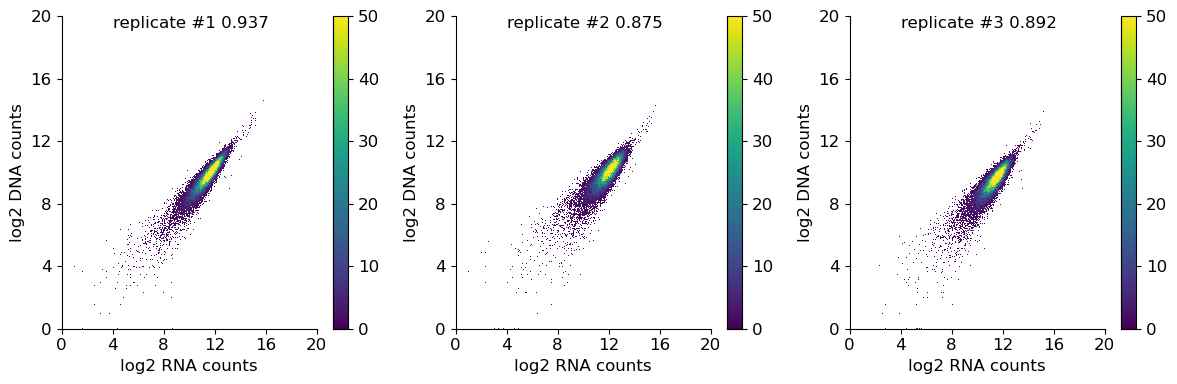

In [17]:
fig, axes = plt.subplots(figsize=(12,4), ncols =3)

graph = plot.pivot_table(index = ['gene_ID','replicate'], columns = ['molecule'], values = 'occurrences',aggfunc='sum').reset_index()


using_datashader(axes[0], np.log2(graph[graph.replicate == '1'].RNA + 1), np.log2(graph[graph.replicate == '1'].DNA +1), 50)
plt.sca(axes[0])
plt.xlabel('log2 RNA counts')
plt.ylabel('log2 DNA counts')
axes[0].text(0.2, 1, 'replicate #1 ' + str(graph[graph.replicate == '1'][['DNA','RNA']].corr().RNA.DNA.round(3)), transform=axes[0].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(0,20)
plt.ylim(0,20)
plt.xticks(np.arange(0,22,4))
plt.yticks(np.arange(0,22,4))

                 
using_datashader(axes[1], np.log2(graph[graph.replicate == '2'].RNA + 1), np.log2(graph[graph.replicate == '2'].DNA +1), 50)
plt.sca(axes[1])
plt.xlabel('log2 RNA counts')
plt.ylabel('log2 DNA counts')
axes[1].text(0.2, 1, 'replicate #2 ' + str(graph[graph.replicate == '2'][['DNA','RNA']].corr().RNA.DNA.round(3)), transform=axes[1].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(0,20)
plt.ylim(0,20)
plt.xticks(np.arange(0,22,4))
plt.yticks(np.arange(0,22,4))




using_datashader(axes[2], np.log2(graph[graph.replicate == '3'].RNA + 1), np.log2(graph[graph.replicate == '3'].DNA +1), 50)
plt.sca(axes[2])
plt.xlabel('log2 RNA counts')
plt.ylabel('log2 DNA counts')
axes[2].text(0.2, 1, 'replicate #3 ' + str(graph[graph.replicate == '3'][['DNA','RNA']].corr().RNA.DNA.round(3)), transform=axes[2].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(0,20)
plt.ylim(0,20)
plt.xticks(np.arange(0,22,4))
plt.yticks(np.arange(0,22,4))




plt.tight_layout()
sns.despine()
plt.savefig('Figures/DNARNAcorrMainGene.pdf')


When something is absent in DNA is absent in RNA?

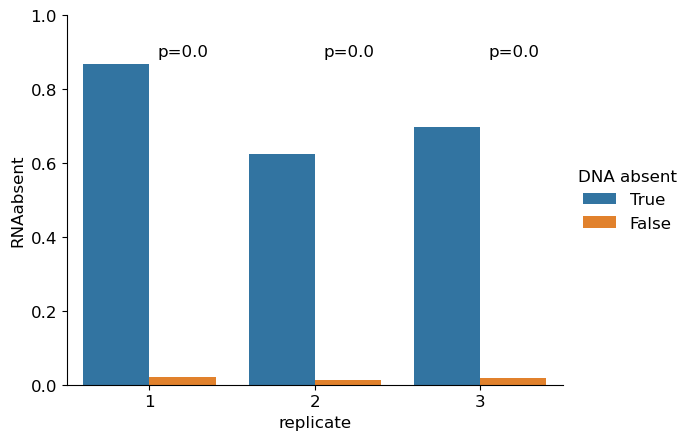

In [13]:
graph = plot.copy()
pd.options.mode.chained_assignment = None  
graph = graph.pivot_table(index=['replicate','UID'], columns = ['molecule'], values=['occurrences']).reset_index()
graph['RNAabsent'] = graph.occurrences.RNA == 0
graph['DNAabsent'] = graph.occurrences.DNA == 0
stats = []
for replicate in ['1','2','3']:
    currFrame = graph[graph.replicate == replicate]
    contingency = pd.crosstab(currFrame.RNAabsent, currFrame.DNAabsent)
    stats += [scipy.stats.fisher_exact(contingency)[1]]
graph = graph.groupby(['replicate','DNAabsent']).RNAabsent.mean().reset_index()
ax = sns.barplot(x= 'replicate', y='RNAabsent', hue='DNAabsent', data=graph, hue_order=[True,False], order=['1','2','3'])
sns.despine()
plt.ylim(0,1)



ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='DNA absent')
position = 0.05
for stat in stats:
    ax.text(position, 0.9, 'p=' + str(stat), va='center', rotation = 'horizontal')
    position += 1

## Run MAGECK

Run Mageck. Start with lower depth run (used to justify second screen targets), with a threshold of 25

In [35]:
mageckData = rawCounts[rawCounts.Sequencing == 'first'].pivot(index = ['gene_ID','UID'], columns = ['molecule','replicate'], values = ['occurrences']).reset_index()
mageckData.columns = mageckData.columns.map('_'.join)
mageckData = mageckData.rename(columns={'gene_ID__':'gene_id',
                                        'UID__':'UID',
                                       'occurrences_DNA_1':'DNA_1',
                                       'occurrences_DNA_2':'DNA_2',
                                       'occurrences_DNA_3':'DNA_3',
                                       'occurrences_RNA_1':'RNA_1',
                                       'occurrences_RNA_2':'RNA_2',
                                       'occurrences_RNA_3':'RNA_3'})
mageckData[['UID','gene_id','DNA_1','RNA_1','DNA_2','RNA_2','DNA_3','RNA_3']].to_csv('Results/mageckInputLowDepth.txt', sep = '\t', index=False)
nontarget = mageckData[mageckData.gene_id.str.slice(stop=12) == 'NonTargeting']
nontarget.UID.to_csv('Results/nontarget.txt', sep = '\t', header=False, index=False)

Mageck with threshold for secondary analysis targets with low depth.

In [31]:
!mageck test -k Results/mageckInputLowDepth.txt -t RNA_1,RNA_2,RNA_3 -c DNA_1,DNA_2,DNA_3 --paired --norm-method control --control-sgrna Results/nontarget.txt --remove-zero control --remove-zero-threshold 25 -n Results/mageckInputLowDepth 

INFO  @ Sun, 13 Apr 2025 11:28:19: Parameters: /tscc/nfs/home/a5russell/mambaforge/envs/NEP/bin/mageck test -k Results/mageckInputLowDepth.txt -t RNA_1,RNA_2,RNA_3 -c DNA_1,DNA_2,DNA_3 --paired --norm-method control --control-sgrna Results/nontarget.txt --remove-zero control --remove-zero-threshold 25 -n Results/mageckInputLowDepth 
INFO  @ Sun, 13 Apr 2025 11:28:19: Welcome to MAGeCK v0.5.9.5. Command: test 
INFO  @ Sun, 13 Apr 2025 11:28:19: Loading count table from Results/mageckInputLowDepth.txt  
INFO  @ Sun, 13 Apr 2025 11:28:19: Processing 1 lines.. 
INFO  @ Sun, 13 Apr 2025 11:28:19: Processing 100001 lines.. 
INFO  @ Sun, 13 Apr 2025 11:28:19: Loaded 119461 records. 
INFO  @ Sun, 13 Apr 2025 11:28:19: 1000 out of 1000 control sgRNAs are found in count table. 
INFO  @ Sun, 13 Apr 2025 11:28:19: Loading Rnw template file: /tscc/nfs/home/a5russell/mambaforge/envs/NEP/lib/python3.12/site-packages/mageck/test_report.Rmd. 
INFO  @ Sun, 13 Apr 2025 11:28:19: Loading R template file: 

Now high depth

In [11]:
mageckData = rawCounts.loc[(rawCounts.Sequencing != 'first') | (rawCounts.molecule == 'DNA'),].pivot(index = ['gene_ID','UID'], columns = ['molecule','replicate'], values = ['occurrences']).reset_index()
mageckData.columns = mageckData.columns.map('_'.join)
mageckData = mageckData.rename(columns={'gene_ID__':'gene_id',
                                        'UID__':'UID',
                                       'occurrences_DNA_1':'DNA_1',
                                       'occurrences_DNA_2':'DNA_2',
                                       'occurrences_DNA_3':'DNA_3',
                                       'occurrences_RNA_1':'RNA_1',
                                       'occurrences_RNA_2':'RNA_2',
                                       'occurrences_RNA_3':'RNA_3'})
mageckData[['UID','gene_id','DNA_1','RNA_1','DNA_2','RNA_2','DNA_3','RNA_3']].to_csv('Results/mageckInput.txt', sep = '\t', index=False)
nontarget = mageckData[mageckData.gene_id.str.slice(stop=12) == 'NonTargeting']
nontarget.UID.to_csv('Results/nontarget.txt', sep = '\t', header=False, index=False)

mageck with no threshold

In [12]:
!mageck test -k Results/mageckInput.txt -t RNA_1,RNA_2,RNA_3 -c DNA_1,DNA_2,DNA_3 --paired --norm-method control --control-sgrna Results/nontarget.txt -n Results/mageckResults 

INFO  @ Thu, 24 Apr 2025 11:57:52: Parameters: /tscc/nfs/home/a5russell/mambaforge/envs/NEP/bin/mageck test -k Results/mageckInput.txt -t RNA_1,RNA_2,RNA_3 -c DNA_1,DNA_2,DNA_3 --paired --norm-method control --control-sgrna Results/nontarget.txt -n Results/mageckResults 
INFO  @ Thu, 24 Apr 2025 11:57:52: Welcome to MAGeCK v0.5.9.5. Command: test 
INFO  @ Thu, 24 Apr 2025 11:57:52: Loading count table from Results/mageckInput.txt  
INFO  @ Thu, 24 Apr 2025 11:57:52: Processing 1 lines.. 
INFO  @ Thu, 24 Apr 2025 11:57:52: Processing 100001 lines.. 
INFO  @ Thu, 24 Apr 2025 11:57:52: Loaded 119461 records. 
INFO  @ Thu, 24 Apr 2025 11:57:52: 1000 out of 1000 control sgRNAs are found in count table. 
INFO  @ Thu, 24 Apr 2025 11:57:52: Loading Rnw template file: /tscc/nfs/home/a5russell/mambaforge/envs/NEP/lib/python3.12/site-packages/mageck/test_report.Rmd. 
INFO  @ Thu, 24 Apr 2025 11:57:52: Loading R template file: /tscc/nfs/home/a5russell/mambaforge/envs/NEP/lib/python3.12/site-packag

# generation of secondary screen.


Assessing sgRNA in the lower-depth sequencing. We wish to pick guides that match our positive genes that had good effect sizes (3) and negative (3). Similarly, we should choose 100 non-targeting guides on the same basis, that they were well represented and produced replicable data.

First, read in all sgData.

Exclude guides with fewer than 25 counts under the control condition.

modify guide names to identical between replicates.

Exclude guides only present in a single replicate (after the former thresholding.)


Read in data, also read in sgData as I am going to require 3 guides, where at least two replicates provide significant results, FDR 0.25, meeting cutoffs indicated elsewhere

In [3]:
mageckResults = pd.read_csv('Results/mageckInputLowDepth.gene_summary.txt', sep='\t')
sgData = pd.read_csv('Results/mageckInputLowDepth.sgrna_summary.txt', sep='\t')
sgData['sgrna'] = sgData['sgrna'].str.slice(0,-3)
sgData = sgData.loc[((sgData.control_count >= 25) & (sgData['FDR'] <= 0.25)),]
sgData = sgData.merge(sgData.groupby(['sgrna']).LFC.max().reset_index().rename(columns = {'LFC':'maxLFC'}))
sgData = sgData.merge(sgData.groupby(['sgrna']).LFC.min().reset_index().rename(columns = {'LFC':'minLFC'}))


Generate a list of negative genes in which to perform a secondary screen.

For now, parameters are at least 8 guides are negative, and 70% of guides recovered are consistent with negative selection, and a change of at least 8-fold down.

At least 3 guides where at least two replicates show significant depletion, and the third cannot show an increase.

A lot of negative genes, so lastly sort by mageck ranking. Then pick the top 3 guides by average pvalue

In [5]:
negList =  mageckResults[(mageckResults['neg|lfc'] <= -3) & (mageckResults['neg|goodsgrna'] >= 8)  & (
    mageckResults['neg|goodsgrna']/mageckResults.num >= 0.7)][['neg|rank', 'id']].rename(columns={'id':'Gene'})
negList = negList.merge(sgData)
#remove any guides where there are positive log-fold changes, as well as those with low changes in general. Be a little loser on this and set -1
negList = negList[(negList.maxLFC <0 ) & (negList.LFC < -3)]
#count how many replicates. Exclude those present in only one replicate
replicatesPresent = negList.groupby(['sgrna','neg|rank'])['score'].count().reset_index().rename(columns = {'score':'replicates'})
negList = negList.merge(replicatesPresent)
negList = negList[negList.replicates >= 2]
#number of guides per gene after thresholding. Collapse replicates first to unique guides.
guidesPerGene = negList.groupby(['Gene','sgrna','neg|rank'])['score'].count().reset_index().rename(columns = {'score':'perGene'})
#now how many unique guides. Max 6, min 1
guidesPerGene = guidesPerGene.groupby(['Gene'])['perGene'].count().reset_index()
negList = negList.merge(guidesPerGene)
negList = negList[negList.perGene >= 3]
geneList = negList.groupby(['Gene', 'neg|rank'])['FDR'].count().reset_index().drop(columns = 'FDR').sort_values('neg|rank').head(150)
                                                                               
negList = negList[negList.Gene.isin(geneList.Gene)]
#now need to just have the top 3 guides per gene
negList = negList.groupby(['Gene','sgrna'])['p.low'].mean().reset_index()
finalnegGuides = []
for gene in set(negList.Gene):
    finalnegGuides += [negList[negList.Gene == gene].sort_values('p.low').head(3)]
finalnegGuides = pd.concat(finalnegGuides)


finalnegGuides.to_csv('Results/negativeList.tsv', sep='\t', index=False)


Generate a list of positive genes in which to perform a secondary screen.

For now, parameters are at least 6 guides are positive, and 50% of guides recovered are consistent with positive selection, and a change of at least 2-fold.

At least 3 guides where at least two replicates show significant enrichment, and the third cannot show a decrease.

not so many positive genes, so keep them all.

In [4]:
posList = mageckResults[(mageckResults['pos|lfc'] >= 1) & (mageckResults['pos|goodsgrna'] >= 6)  & (
    mageckResults['pos|goodsgrna']/mageckResults.num >= 0.5)][['pos|rank', 'id']].rename(columns={'id':'Gene'})

posList = posList.merge(sgData)
#remove any guides where there are negative log-fold changes, as well as those with low changes in general. Be a little loser on this and set -1
posList = posList[(posList.minLFC > 0 ) & (posList.LFC > 1)]
#count how many replicates. Exclude those present in only one replicate
replicatesPresent = posList.groupby(['sgrna','pos|rank'])['score'].count().reset_index().rename(columns = {'score':'replicates'})
posList = posList.merge(replicatesPresent)
posList = posList[posList.replicates >= 2]
#number of guides per gene after thresholding. Collapse replicates first to unique guides.
guidesPerGene = posList.groupby(['Gene','sgrna','pos|rank'])['score'].count().reset_index().rename(columns = {'score':'perGene'})
#now how many unique guides. Max 6, min 1
guidesPerGene = guidesPerGene.groupby(['Gene'])['perGene'].count().reset_index()
posList = posList.merge(guidesPerGene)
posList = posList[posList.perGene >= 3]
geneList = posList.groupby(['Gene', 'pos|rank'])['FDR'].count().reset_index().drop(columns = 'FDR').sort_values('pos|rank').head(150)
                                                                               
posList = posList[posList.Gene.isin(geneList.Gene)]
#now need to just have the top 3 guides per gene
posList = posList.groupby(['Gene','sgrna'])['p.high'].mean().reset_index()
finalposGuides = []
for gene in set(posList.Gene):
    finalposGuides += [posList[posList.Gene == gene].sort_values('p.high').head(3)]
finalposGuides = pd.concat(finalposGuides)


finalposGuides.to_csv('Results/positiveList.tsv', sep='\t', index=False)



Now need to select the 100 nontargeting guides. Reread in sgRNA, but now looking for no effect.

In [8]:
sgData = pd.read_csv('Results/mageckInputLowDepth.sgrna_summary.txt', sep='\t')
sgData['sgrna'] = sgData['sgrna'].str.slice(0,-3)
sgData = sgData.loc[((sgData.control_count >= 25) & (sgData['FDR'] > 0.25)),]
sgData = sgData.merge(sgData.groupby(['sgrna']).LFC.max().reset_index().rename(columns = {'LFC':'maxLFC'}))
sgData = sgData.merge(sgData.groupby(['sgrna']).LFC.min().reset_index().rename(columns = {'LFC':'minLFC'}))
sgData = sgData[sgData.Gene.str.slice(0,len('NonTargeting')) == 'NonTargeting']
#can go ahead and only consider max and min, as by definition it will exclude any guides that don't match
sgData = sgData.loc[ (sgData.maxLFC < 1) & (sgData.minLFC > -1),]
replicatesPresent = sgData.groupby(['sgrna',])['LFC'].count().reset_index().rename(columns = {'LFC':'replicates'})
sgData = sgData.merge(replicatesPresent)
#require 3 replicates, why not
sgData = sgData[sgData.replicates >= 3]

finalNTguides = pd.DataFrame({'sgrna':list(set(sgData.sgrna))[:100]})
finalNTguides.to_csv('Results/ntList.tsv', sep='\t', index=False)




Recover sequences and put out to a file for ordering.

In [24]:
UpSequence = 'TTGTGGAAAGGACGAAACACCG'
DownSequence = 'GTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTT'

finalData = pd.concat([finalposGuides.sgrna, finalnegGuides.sgrna, finalNTguides])
finalData = finalData.merge(rawCounts[['sequence', 'UID']].set_index('UID').sort_index().drop_duplicates().reset_index().rename(columns={'UID':'sgrna'}))
finalData['sequence'] = UpSequence + finalData.sequence + DownSequence
finalData.to_csv('Results/secondaryScreenSequence.tsv',sep = '\t', index=False)

# Analysis of secondary screen paremeters.

In [26]:

def analyze(file):
    unzipped = file[:-3]
    name = os.path.basename(file)
    replicate = name.split('_')[0][-1]
    molecule = name.split('_')[0][-2]
    if molecule == 'D':
        molecule = 'DNA'
    if molecule == 'R':
        molecule = 'RNA'
    !gunzip -c $file | grep -i CGAAACACCG | grep -i GTTTTAGAGCTAG > $unzipped
    GuideAssign.quickAssign(infile = unzipped, outfile = 'Results/smallerScreen_' + replicate + '_' + molecule + '.tsv', upSeq = 'CGAAACACCG', downSeq='GTTTTAGAGCTAG', guideLength=20,
                           guideDirectory='Database/secondaryScreen', rc=False)
    !rm -f $unzipped

popList = [file for file in glob.glob('Sequencing/smallerScreen/*_R1_*.gz')]
while len(popList) > 0:
    with Pool(processes = numProcessors) as p:
        p.map(analyze, [popList.pop() for i in range(numProcessors) if len(popList) != 0])

In [40]:
rawCounts = []
for file in glob.glob('Results/smallerScreen*DNA.tsv'):
    replicate = os.path.basename(file).split('_')[1]
    currFrame = pd.read_csv(file, sep='\t')
    currFrame['molecule'] = 'DNA'
    currFrame['replicate'] = replicate
    rawCounts += [currFrame]
for file in glob.glob('Results/smallerScreen*RNA.tsv'):
    replicate = os.path.basename(file).split('_')[1]
    currFrame = pd.read_csv(file, sep='\t')
    currFrame['molecule'] = 'RNA'
    currFrame['replicate'] = replicate
    rawCounts += [currFrame]
rawCounts = pd.concat(rawCounts)

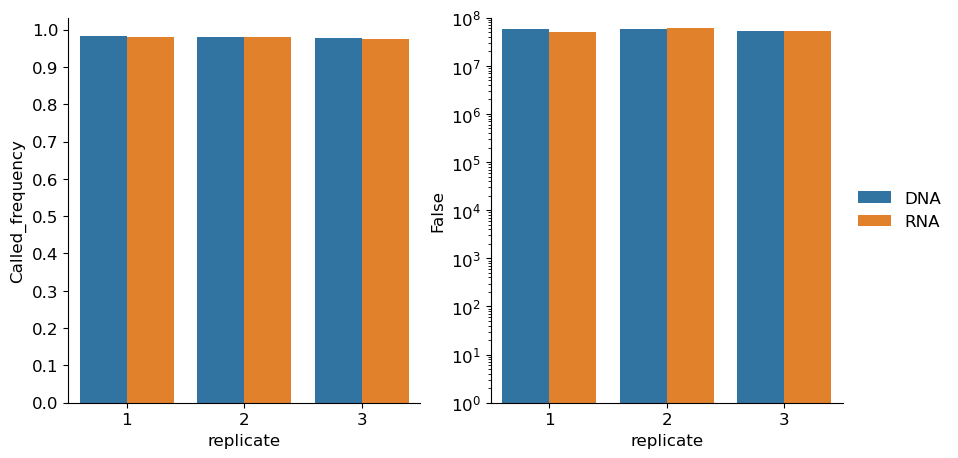

In [41]:
plot = rawCounts.copy()
plot['unknown'] = plot.UID == 'unknown'
plot = plot.groupby(['unknown','molecule','replicate']).occurrences.sum().reset_index()
plot = plot.pivot_table(index=['replicate','molecule'], columns=['unknown'], values=['occurrences']).reset_index()
plot['Called_frequency'] = plot.occurrences[False]/(plot.occurrences[False] + plot.occurrences[True])
f, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(x=plot.replicate, y=plot.Called_frequency, ax=axes[0], hue=plot.molecule)
sns.despine()
axes[0].get_legend().remove()
plt.ylim(0, 1)
axes[0].set_yticks(np.arange(0,1.1,0.1))
sns.barplot(x=plot.replicate, y=plot.occurrences[False], ax=axes[1], hue=plot.molecule)
sns.despine()
plt.yscale('log')
plt.ylim(1, 100000000)
axes[1].legend( loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)


No guides are absent.

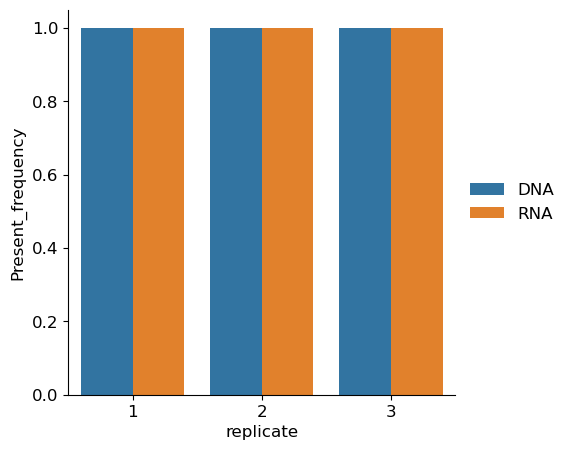

In [42]:
rawCounts = rawCounts[rawCounts.UID != 'unknown']
plot = rawCounts.copy()
plot['absent'] = plot.occurrences == 0
plot = plot.groupby(['absent','molecule','replicate']).occurrences.count().reset_index()
if (len(set(plot['absent'])) == 1) & ~(plot.iloc[0].absent):
    plot = plot.pivot_table(index=['replicate','molecule'], columns=['absent'], values=['occurrences']).reset_index()
    plot['Present_frequency'] = 1

else:
    
    plot = plot.pivot_table(index=['replicate','molecule'], columns=['absent'], values=['occurrences']).reset_index()
    plot['Present_frequency'] = plot.occurrences[False]/(plot.occurrences[False] + plot.occurrences[True])

f, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x=plot.replicate, y=plot.Present_frequency, ax=axes, hue=plot.molecule)
sns.despine()
axes.legend( loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)


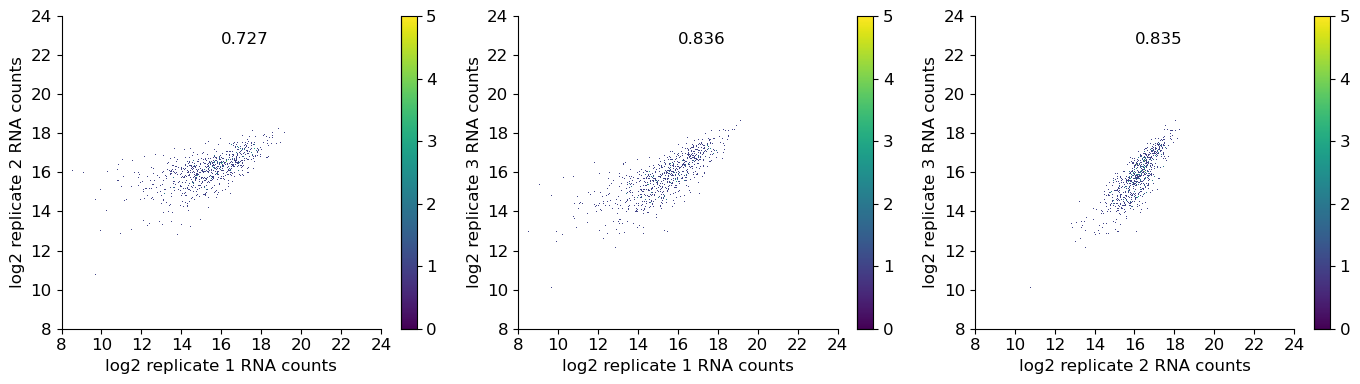

In [43]:
fig, axes = plt.subplots(figsize=(14,4), ncols =3)

plot = rawCounts.copy()

RNA = plot.loc[plot.molecule == 'RNA',]
RNA = RNA.pivot(index = 'UID', columns = 'replicate', values = 'occurrences')
using_datashader(axes[0], np.log2(RNA['1'] + 1), np.log2(RNA['2'] +1), 5)
plt.sca(axes[0])
plt.xlabel('log2 replicate 1 RNA counts')
plt.ylabel('log2 replicate 2 RNA counts')
axes[0].text(0.5, 0.95, str(str(RNA.corr()['2']['1'].round(3))), transform=axes[0].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(8,24)
plt.ylim(8,24)
plt.xticks(np.arange(8,26,2))

using_datashader(axes[1], np.log2(RNA['1'] + 1), np.log2(RNA['3'] +1), 5)
plt.sca(axes[1])
plt.xlabel('log2 replicate 1 RNA counts')
plt.ylabel('log2 replicate 3 RNA counts')
axes[1].text(0.5, 0.95, str(str(RNA.corr()['3']['1'].round(3))), transform=axes[1].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(8,24)
plt.ylim(8,24)
plt.xticks(np.arange(8,26,2))



using_datashader(axes[2], np.log2(RNA['2'] + 1), np.log2(RNA['3'] +1), 5)
plt.sca(axes[2])
plt.xlabel('log2 replicate 2 RNA counts')
plt.ylabel('log2 replicate 3 RNA counts')
axes[2].text(0.5, 0.95, str(str(RNA.corr()['2']['3'].round(3))), transform=axes[2].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(8,24)
plt.ylim(8,24)
plt.xticks(np.arange(8,26,2))




plt.tight_layout()
sns.despine()

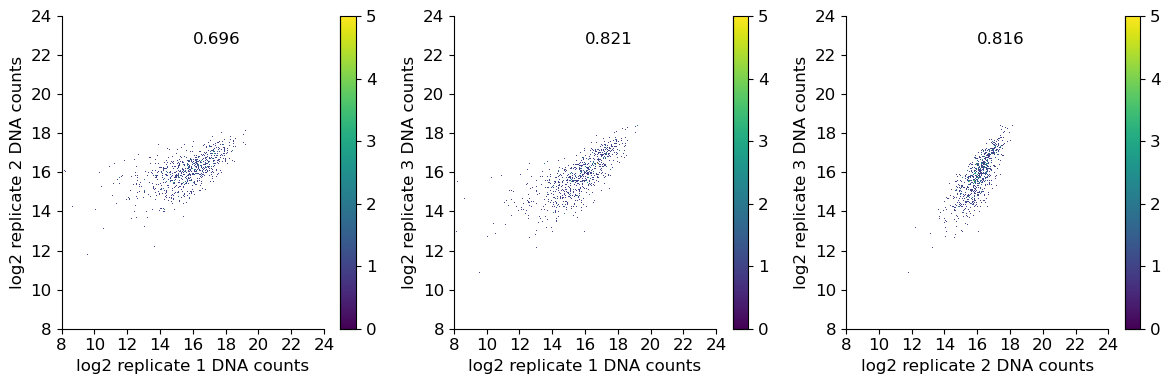

In [44]:
fig, axes = plt.subplots(figsize=(12,4), ncols =3)


DNA = plot.loc[plot.molecule == 'DNA',]
DNA = DNA.pivot(index = 'UID', columns = 'replicate', values = 'occurrences')
using_datashader(axes[0], np.log2(DNA['1'] + 1), np.log2(DNA['2'] +1), 5)
plt.sca(axes[0])
plt.xlabel('log2 replicate 1 DNA counts')
plt.ylabel('log2 replicate 2 DNA counts')
axes[0].text(0.5, 0.95, str(str(DNA.corr()['2']['1'].round(3))), transform=axes[0].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(8,24)
plt.ylim(8,24)
plt.xticks(np.arange(8,26,2))
                 
using_datashader(axes[1], np.log2(DNA['1'] + 1), np.log2(DNA['3'] +1), 5)
plt.sca(axes[1])
plt.xlabel('log2 replicate 1 DNA counts')
plt.ylabel('log2 replicate 3 DNA counts')
axes[1].text(0.5, 0.95, str(str(DNA.corr()['3']['1'].round(3))), transform=axes[1].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(8,24)
plt.ylim(8,24)
plt.xticks(np.arange(8,26,2))
                 


using_datashader(axes[2], np.log2(DNA['2'] + 1), np.log2(DNA['3'] +1), 5)
plt.sca(axes[2])
plt.xlabel('log2 replicate 2 DNA counts')
plt.ylabel('log2 replicate 3 DNA counts')
axes[2].text(0.5, 0.95, str(str(DNA.corr()['2']['3'].round(3))), transform=axes[2].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(8,24)
plt.ylim(8,24)
plt.xticks(np.arange(8,26,2))
                 


plt.tight_layout()
sns.despine()

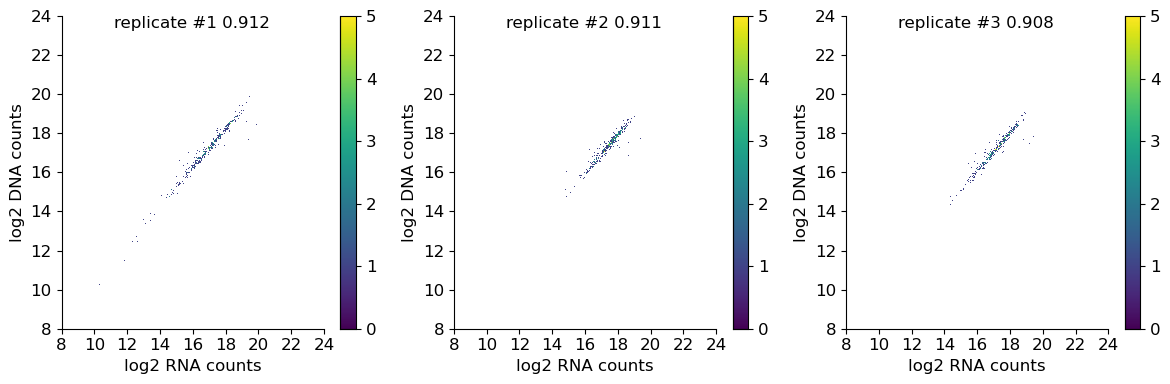

In [45]:
fig, axes = plt.subplots(figsize=(12,4), ncols =3)

graph = plot.pivot_table(index = ['gene_ID','replicate'], columns = ['molecule'], values = 'occurrences',aggfunc='sum').reset_index()


using_datashader(axes[0], np.log2(graph[graph.replicate == '1'].RNA + 1), np.log2(graph[graph.replicate == '1'].DNA +1), 5)
plt.sca(axes[0])
plt.xlabel('log2 RNA counts')
plt.ylabel('log2 DNA counts')
axes[0].text(0.2, 1, 'replicate #1 ' + str(graph[graph.replicate == '1'][['DNA','RNA']].corr().RNA.DNA.round(3)), transform=axes[0].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(0,20)
plt.ylim(0,20)
plt.xlim(8,24)
plt.ylim(8,24)
plt.xticks(np.arange(8,26,2))
                 
                 
using_datashader(axes[1], np.log2(graph[graph.replicate == '2'].RNA + 1), np.log2(graph[graph.replicate == '2'].DNA +1), 5)
plt.sca(axes[1])
plt.xlabel('log2 RNA counts')
plt.ylabel('log2 DNA counts')
axes[1].text(0.2, 1, 'replicate #2 ' + str(graph[graph.replicate == '2'][['DNA','RNA']].corr().RNA.DNA.round(3)), transform=axes[1].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(0,20)
plt.ylim(0,20)
plt.xlim(8,24)
plt.ylim(8,24)
plt.xticks(np.arange(8,26,2))
                 




using_datashader(axes[2], np.log2(graph[graph.replicate == '3'].RNA + 1), np.log2(graph[graph.replicate == '3'].DNA +1), 5)
plt.sca(axes[2])
plt.xlabel('log2 RNA counts')
plt.ylabel('log2 DNA counts')
axes[2].text(0.2, 1, 'replicate #3 ' + str(graph[graph.replicate == '3'][['DNA','RNA']].corr().RNA.DNA.round(3)), transform=axes[2].transAxes, fontsize=12, va='top', ha='left')
plt.xlim(0,20)
plt.ylim(0,20)
plt.xlim(8,24)
plt.ylim(8,24)
plt.xticks(np.arange(8,26,2))
                 



plt.tight_layout()
sns.despine()

# Run MAGECK from smaller screen for further comparisons.

In [47]:
mageckData = rawCounts.pivot(index = ['gene_ID','UID'], columns = ['molecule','replicate'], values = ['occurrences']).reset_index()
mageckData.columns = mageckData.columns.map('_'.join)
mageckData = mageckData.rename(columns={'gene_ID__':'gene_id',
                                        'UID__':'UID',
                                       'occurrences_DNA_1':'DNA_1',
                                       'occurrences_DNA_2':'DNA_2',
                                       'occurrences_DNA_3':'DNA_3',
                                       'occurrences_RNA_1':'RNA_1',
                                       'occurrences_RNA_2':'RNA_2',
                                       'occurrences_RNA_3':'RNA_3'})
mageckData[['UID','gene_id','DNA_1','RNA_1','DNA_2','RNA_2','DNA_3','RNA_3']].to_csv('Results/mageckInputSecondary.txt', sep = '\t', index=False)
nontarget = mageckData[mageckData.gene_id.str.slice(stop=12) == 'NonTargeting']
nontarget.UID.to_csv('Results/nontargetSecondary.txt', sep = '\t', header=False, index=False)

In [48]:
!mageck test -k Results/mageckInputSecondary.txt -t RNA_1,RNA_2,RNA_3 -c DNA_1,DNA_2,DNA_3 --paired --norm-method control --control-sgrna Results/nontargetSecondary.txt  -n Results/mageckInputSecondary 

INFO  @ Wed, 16 Apr 2025 11:08:26: Parameters: /tscc/nfs/home/a5russell/mambaforge/envs/NEP/bin/mageck test -k Results/mageckInputSecondary.txt -t RNA_1,RNA_2,RNA_3 -c DNA_1,DNA_2,DNA_3 --paired --norm-method control --control-sgrna Results/nontargetSecondary.txt -n Results/mageckInputSecondary 
INFO  @ Wed, 16 Apr 2025 11:08:26: Welcome to MAGeCK v0.5.9.5. Command: test 
INFO  @ Wed, 16 Apr 2025 11:08:26: Loading count table from Results/mageckInputSecondary.txt  
INFO  @ Wed, 16 Apr 2025 11:08:26: Processing 1 lines.. 
INFO  @ Wed, 16 Apr 2025 11:08:26: Loaded 742 records. 
INFO  @ Wed, 16 Apr 2025 11:08:26: 94 out of 94 control sgRNAs are found in count table. 
INFO  @ Wed, 16 Apr 2025 11:08:26: Loading Rnw template file: /tscc/nfs/home/a5russell/mambaforge/envs/NEP/lib/python3.12/site-packages/mageck/test_report.Rmd. 
INFO  @ Wed, 16 Apr 2025 11:08:26: Loading R template file: /tscc/nfs/home/a5russell/mambaforge/envs/NEP/lib/python3.12/site-packages/mageck/plot_template.RTemplate. 